**Tâche : Importation des bibliothèques de base**

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from utils import display_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [49]:
df = pd.read_csv('energy_antananarivo_cleaned.csv',index_col='date',parse_dates=True)

In [70]:
df.describe()

,tot_nb_dmd
count,516.000000
mean,1539.323643
std,872.617657
min,16.000000
25%,780.000000
50%,1521.500000
75%,2283.250000
max,3162.000000


In [51]:
df = df.drop('tot_energy', axis=1)

**Tâche : Traçage des séries temporelles**

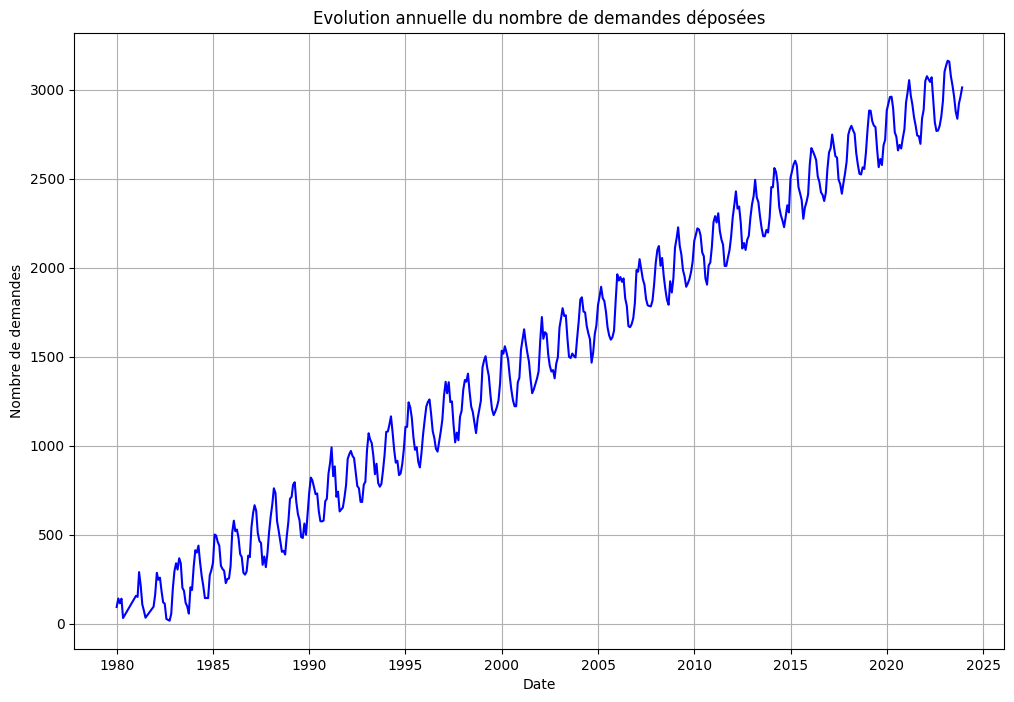

In [73]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.tot_nb_dmd, color='blue')
plt.title('Evolution annuelle du nombre de demandes déposées')
plt.xlabel('Date')
plt.ylabel('Nombre de demandes')
plt.grid(True)
plt.show()

## Répartition Entraînement / Test

**Tâche : Définition de la longueur (taille) du dataset**

In [53]:
# Créer des ensembles de train et de test
train_df, test_df = train_test_split(df, test_size=0.15, shuffle=False)

# Afficher les tailles des ensembles
print("Taille de l'ensemble d'entraînement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entraînement : 438
Taille de l'ensemble de test : 78


## Mise à l'échelle des données

**Tâche : Utilisation de la classe MinMaxScaler pour mettre à l'échelle les ensembles de données d'entraînement et de test dans leurs versions mises à l'échelle.**

In [54]:
scaler = MinMaxScaler()

In [55]:
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train_df)

MinMaxScaler()

In [56]:
scaled_train = scaler.transform(train_df)
scaled_test = scaler.transform(test_df)

## Générateur de séries temporelles

**Tâche : Création d'un objet TimeSeriesGenerator qui se base sur les données scaled_train. La longueur du batch doit être au minimum de 12 pour saisir une saisonnalité d'une année complète.**

In [57]:
length = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Création du modèle avec Simple RNN

**Tâche : Création d'un modèle séquentiel de Keras avec des neurones (units).**

In [58]:
# définir le modèle
model = Sequential()
model.add(SimpleRNN(75, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 75)             │         5,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# ajustement du modèle
model.fit(generator,epochs=5)

Epoch 1/5


426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0235
Epoch 2/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.4139e-04
Epoch 3/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.4689e-04
Epoch 4/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.8915e-04
Epoch 5/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.3659e-04


**Tâche : Traçage l'historique des pertes survenues pendant l'entraînement.**

<Axes: >

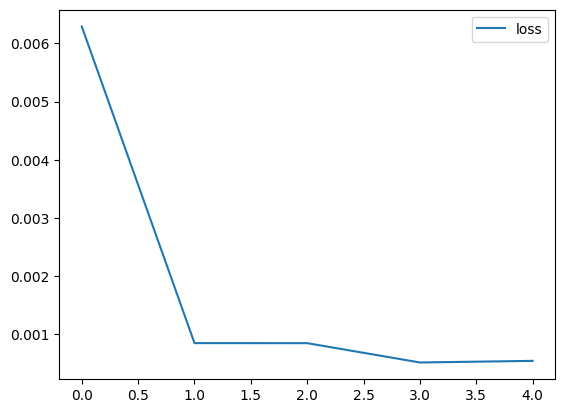

In [61]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Évaluation sur les données Test

**Tâche : Prédictions pour la gamme de données de test (les 12 derniers mois de l'ensemble des données).**

In [62]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test_df)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [63]:
true_predictions = scaler.inverse_transform(test_predictions)

In [64]:
test_df['Simple RNN Predictions'] = true_predictions

**Tâche : Calcul de RMSE.**

In [69]:
# Mesures de performances sur l'ensemble de test
test_mae = mean_absolute_error(test_df['tot_nb_dmd'], true_predictions)
test_mse = mean_squared_error(test_df['tot_nb_dmd'], true_predictions)
test_rmse = mean_squared_error(test_df['tot_nb_dmd'], true_predictions, squared=False)
test_r2 = r2_score(test_df['tot_nb_dmd'], true_predictions)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

,Métriques:,Ensemble de test:
0,MAE,632.805045
1,MSE,466855.287142
2,RMSE,683.268093
3,R²,-13.304715


**Tâche : Traçage vos prédictions en fonction des valeurs réels (et vrais) du test.**

<Axes: xlabel='date'>

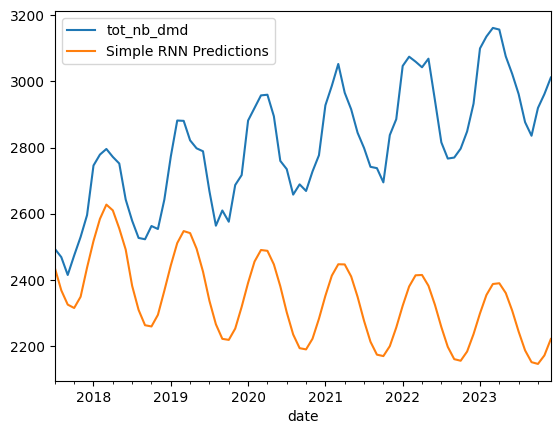

In [ ]:
test_df.plot()

In [ ]:
df.describe()

,tot_nb_dmd
count,516.000000
mean,1539.323643
std,872.617657
min,16.000000
25%,780.000000
50%,1521.500000
75%,2283.250000
max,3162.000000
